In [340]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

In [341]:
sequences = np.array([[0, 0, 0, 0], [0, 0, 1, 0], [1, 1, 0, 0], [1,0,1,1]])

In [342]:
counts = np.array([1000, 1200, 750, 300])

In [343]:
sequencing_error_rates = np.array([0.01, 0.02, 0.03, 0.05])

In [344]:
def add_sequence_error(sequences, counts, sequencing_error_rates):
    
    full_sequences = np.repeat(sequences, np.round(counts).astype(int), axis=0)
    # add errors per position according to the error rates
    for i in range(full_sequences.shape[1]):
        error = np.random.binomial(1, sequencing_error_rates[i], full_sequences.shape[0])
        full_sequences[:, i] = (full_sequences[:, i] + error) % 2
    # make sequences unique
    sequences_with_errors, counts_with_errors = np.unique(full_sequences, axis=0, return_counts=True)

    sequences_with_errors_matched = []
    counts_matched = []

    #match the error sequences with the original sequences
    for seq in range(sequences.shape[0]):
        # find the matching sequences
        matching = np.where(np.all(sequences[seq] == sequences_with_errors, axis=1))[0]
        # if there are matching sequences, add them to the list
        if len(matching) > 0:
            sequences_with_errors_matched.append(sequences_with_errors[matching][0])
            counts_matched.append(counts_with_errors[matching][0])
    # convert to numpy arrays
    sequences_with_errors_matched = np.array(sequences_with_errors_matched)
    counts_matched = np.array(counts_matched)
            

    return sequences_with_errors, counts_with_errors, sequences_with_errors_matched, counts_matched
        

In [345]:
sequences_with_error, counts_with_error, sequences_with_errors_matched, counts_matched = add_sequence_error(sequences, counts, sequencing_error_rates)
print(sequences_with_error)
print(counts_with_error)
print(sequences_with_errors_matched)
print(counts_matched)

[[0 0 0 0]
 [0 0 0 1]
 [0 0 1 0]
 [0 0 1 1]
 [0 1 0 0]
 [0 1 0 1]
 [0 1 1 0]
 [0 1 1 1]
 [1 0 0 0]
 [1 0 0 1]
 [1 0 1 0]
 [1 0 1 1]
 [1 1 0 0]
 [1 1 0 1]
 [1 1 1 0]
 [1 1 1 1]]
[ 930   48 1090   72   29    3   18    2   16    9   27  267  662   42
   27    8]
[[0 0 0 0]
 [0 0 1 0]
 [1 1 0 0]
 [1 0 1 1]]
[ 930 1090  662  267]


In [346]:
# check shape of counts and cpunts_matched
print(counts_matched.shape)
print(counts.shape)

(4,)
(4,)


In [347]:
# find a initial count distribution that if the error function is applied to it repeatedly, it will consistently match the observed error distribution
# the initial count distribution should be a random distribution that is not too far from the observed distribution

def find_initial_distribution(sequences, counts, sequencing_error_rates, n_iter=100000):
    # create a random initial distribution
    initial_counts = np.random.randint(0, 100, counts.shape)
    # normalize the initial distribution
    initial_counts = np.round(initial_counts / np.sum(initial_counts) * np.sum(counts)).astype(int)
    candidates = []
    best_kl = np.inf
    best_counts = None
    kl_list = []
    # apply the error function to the initial distribution
    for i in range(n_iter):
        sequences_with_error, counts_with_error, sequences_with_errors_matched, counts_matched = add_sequence_error(sequences, initial_counts, sequencing_error_rates)
        # if the error function matches the observed distribution, return the initial distribution
        if np.all(counts_matched == counts):
            # add the initial distribution to the candidates
            candidates.append(initial_counts)
        else:
            # compute KL divergence
            kl = stats.entropy(counts, counts_matched)
            kl_list.append(kl)
            # if the KL divergence is smaller than the best KL divergence, update the best KL divergence
            if kl < best_kl:
                best_kl = kl
                best_counts = initial_counts
            # if the error function does not match the observed distribution, update the initial distribution
            initial_counts = initial_counts + (counts - counts_matched) #+ np.random.randint(-2, 2, counts.shape)
    # if no candidate was found, return None
    if len(candidates) == 0:
        print("No exact match found")
        print(f"Best KL divergence: {best_kl}, for initial distribution: {best_counts}")
        return best_counts, best_kl, kl_list
    
    print(f"Found {len(candidates)} candidates")
    # return all most common candidate
    candidates = np.array(candidates)
    candidates, counts = np.unique(candidates, axis=0, return_counts=True)
    ml_candidates = candidates[np.flatnonzero(counts == np.max(counts))]
    print(f"Found {ml_candidates.shape[0]} most common candidates with {np.max(counts)} occurences")
    print(ml_candidates)
    
    #return median candidate
    mean_ml_candidate = np.mean(ml_candidates, axis=0)
    print("Mean ML candidate")
    print(mean_ml_candidate)

    return ml_candidates, mean_ml_candidate, kl_list

In [348]:
print("true counts:", counts)
print("observed counts:", counts_matched)
# find the initial distribution
ml_counts, median_counts, kl_list = find_initial_distribution(sequences, counts_matched, sequencing_error_rates)
# print(ml_counts)
# print(median_counts)

true counts: [1000 1200  750  300]
observed counts: [ 930 1090  662  267]
No exact match found
Best KL divergence: 4.3503481449294135e-08, for initial distribution: [1013 1175  733  289]


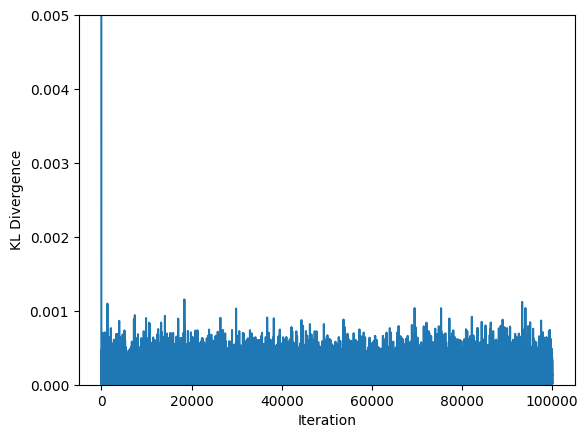

In [349]:
# plot the KL divergence over the iterations
plt.plot(kl_list)
plt.xlabel("Iteration")
plt.ylabel("KL Divergence")
plt.ylim(0, .005)
plt.show()